# # Speaker recognition dense neural network

Import neccessary packages.

In [1]:
import IPython.display as ipd
import os
import pandas as pd
import numpy as np 
import librosa
import glob
import librosa.display
import random
from datetime import datetime

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_regression

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical

c:\users\yanina.husarevych\appdata\local\programs\python\python38\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\users\yanina.husarevych\appdata\local\programs\python\python38\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using TensorFlow backend.


In [2]:
def create_dataframe(name_of_speaker):
    filename = 'data/' + name_of_speaker
    files = os.listdir(filename)
    df_name_of_speaker = pd.DataFrame(files)
    df_name_of_speaker['label'] = name_of_speaker
    return df_name_of_speaker

In [12]:
speakers = os.listdir('data')
dataframes = list()
for speaker in speakers:
    dataframes.append(create_dataframe(speaker))

In [13]:
df = pd.concat(dataframes, ignore_index=True)
df = df.rename(columns={0:'file'})
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)

                             file   label
0              anya_38wSDfbf.flac    Anya
1              anya_FYsAzM7X.flac    Anya
2              anya_GOJr0GMR.flac    Anya
3              anya_hUzGAi6R.flac    Anya
4              anya_HXEyt3mG.flac    Anya
5              anya_IhSDrcuP.flac    Anya
6              anya_jgdQatCk.flac    Anya
7              anya_JOYvWWEJ.flac    Anya
8              anya_kl9x9L0D.flac    Anya
9              anya_MHi22iAU.flac    Anya
10             anya_n6DE18lk.flac    Anya
11             anya_osnAsQbv.flac    Anya
12             anya_paWKeEEy.flac    Anya
13             anya_qG5obQ2E.flac    Anya
14             anya_qYA2Xubc.flac    Anya
15             anya_rlhJSkPY.flac    Anya
16             anya_St13Q2kZ.flac    Anya
17             anya_y12D4pEp.flac    Anya
18             anya_ZFJbMS7J.flac    Anya
19   dara1-1hw4krts_0MLWQKNT.flac    Dara
20   dara1-1hw4krts_vebxJSBZ.flac    Dara
21   dara1-lw72o7d2_Bf7ZlorE.flac    Dara
22   dara1-lw72o7d2_U1DNf662.flac 

In [14]:
df = df.sample(frac=1).reset_index(drop=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)

                             file   label
0              vlad_vhcqgKod.flac    Vlad
1              oleh_Q9LFW1yX.flac    Oleh
2              vlad_mSzaqDpb.flac    Vlad
3             marya_5Gxj5PKP.flac   Marya
4              vlad_lqY1x660.flac    Vlad
5            olesya_xtjF2pFM.flac  Olesya
6            olesya_ZyIADQvO.flac  Olesya
7              lana_SGbN955q.flac    Lana
8              vlad_eBac8QAq.flac    Vlad
9             marya_98XI8qC3.flac   Marya
10            marya_Tq2iWWd7.flac   Marya
11            dara3_fpQOI1Ox.flac    Dara
12             oleh_vFbKUuuC.flac    Oleh
13             oleh_iPNOCmPQ.flac    Oleh
14             oleh_TK9u1X5y.flac    Oleh
15            dara3_jF476mtL.flac    Dara
16             lana_NErkueJ1.flac    Lana
17             oleh_YhTifb1T.flac    Oleh
18             lana_OtEJlnkv.flac    Lana
19             anya_qYA2Xubc.flac    Anya
20             oleh_NB5MI00r.flac    Oleh
21           olesya_o4NtDV5i.flac  Olesya
22            marya_MsbErELY.flac 

In [15]:
df_train = df[:100]

In [16]:
print(df_train['label'].value_counts(normalize=True))

Marya     0.18
Dara      0.17
Vlad      0.14
Lana      0.12
Olesya    0.11
Oleh      0.11
Anya      0.10
Tanya     0.07
Name: label, dtype: float64


In [17]:
df_validation = df[100:130]

In [18]:
print(df_validation['label'].value_counts(normalize=True))

Lana      0.200000
Anya      0.200000
Tanya     0.133333
Dara      0.133333
Olesya    0.100000
Marya     0.100000
Oleh      0.100000
Vlad      0.033333
Name: label, dtype: float64


In [19]:
def extract_features_from_audio(audio_files):
    fname = os.path.join(os.path.abspath('data') + '/' + str(audio_files.label) + '/' + str(audio_files.file))
    X, sample_rate = librosa.load(fname, res_type='kaiser_fast')
    mfcc = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    stft = np.abs(librosa.stft(X))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    mel_scaled_spectrogram = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
    label = audio_files.label
    return mfcc, chroma, mel_scaled_spectrogram, contrast, tonnetz, label

In [20]:
start_timer = datetime.now()
features_lab = df.apply(extract_features_from_audio, axis=1)
print(datetime.now() - start_timer)

0:08:04.820008


In [21]:
np.save('features_label', features_lab)

In [22]:
# features_lab = np.load('features_label.npy', allow_pickle=True)

In [23]:
features = []
for i in range(0, len(features_lab)):
    features.append(np.concatenate((features_lab[i][0], features_lab[i][1], 
                features_lab[i][2], features_lab[i][3],
                features_lab[i][4]), axis=0))

In [24]:
print(len(features))

161


In [25]:
labels = df.label
labels

0        Vlad
1        Oleh
2        Vlad
3       Marya
4        Vlad
        ...  
156     Tanya
157    Olesya
158    Olesya
159     Marya
160    Olesya
Name: label, Length: 161, dtype: object

In [28]:
X = np.array(features)

In [29]:
Y = np.array(labels)

In [30]:
lb = LabelEncoder()
Y = to_categorical(lb.fit_transform(Y))

In [31]:
X.shape

(161, 193)

In [32]:
Y.shape

(161, 8)

In [33]:
X_train = X[:100]
Y_train = Y[:100]
X_val = X[100:130]
Y_val = Y[100:130]
X_test = X[130:]
Y_test = Y[130:]

In [34]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [35]:
model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(8, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [36]:
history = model.fit(X_train, Y_train, batch_size=256, epochs=100, 
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stop])

Train on 100 samples, validate on 30 samples
Epoch 1/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3245 - accuracy: 0.0700 - val_loss: 1.8094 - val_accuracy: 0.3000
Epoch 2/100
100/100 [==============================] - 0s 60us/step - loss: 1.9027 - accuracy: 0.2300 - val_loss: 1.6255 - val_accuracy: 0.4333
Epoch 3/100
100/100 [==============================] - 0s 70us/step - loss: 1.7012 - accuracy: 0.3900 - val_loss: 1.4731 - val_accuracy: 0.6000
Epoch 4/100
100/100 [==============================] - 0s 70us/step - loss: 1.6038 - accuracy: 0.3600 - val_loss: 1.3444 - val_accuracy: 0.7000
Epoch 5/100
100/100 [==============================] - 0s 80us/step - loss: 1.4112 - accuracy: 0.5800 - val_loss: 1.2289 - val_accuracy: 0.7667
Epoch 6/100
100/100 [==============================] - 0s 70us/step - loss: 1.3053 - accuracy: 0.6100 - val_loss: 1.1270 - val_accuracy: 0.8333
Epoch 7/100
100/100 [==============================] - 0s 70us/step - loss: 1.1798 - accurac

Epoch 57/100
100/100 [==============================] - 0s 70us/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 2.0792e-04 - val_accuracy: 1.0000
Epoch 58/100
100/100 [==============================] - 0s 80us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.8771e-04 - val_accuracy: 1.0000
Epoch 59/100
100/100 [==============================] - 0s 70us/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.7014e-04 - val_accuracy: 1.0000
Epoch 60/100
100/100 [==============================] - 0s 60us/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.5481e-04 - val_accuracy: 1.0000
Epoch 61/100
100/100 [==============================] - 0s 70us/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 1.4112e-04 - val_accuracy: 1.0000
Epoch 62/100
100/100 [==============================] - 0s 60us/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 1.2982e-04 - val_accuracy: 1.0000
Epoch 63/100
100/100 [==============================] - 0s 80us/step - loss: 0.0058 - accuracy: 1.0000 - v

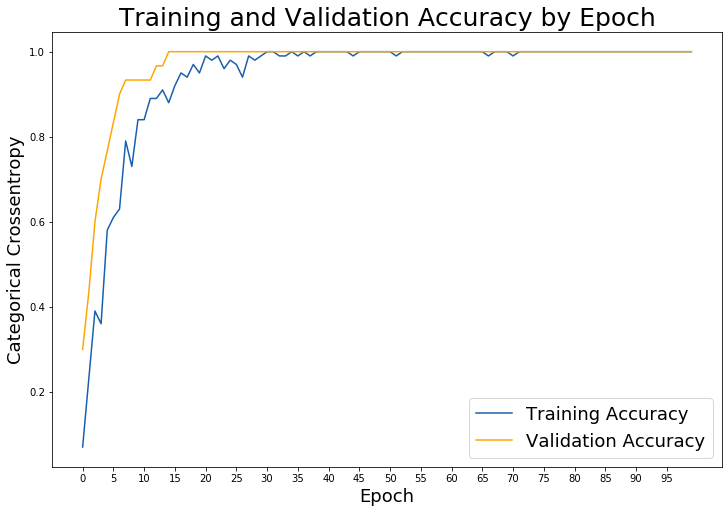

In [37]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

In [38]:
preds = model.predict_classes(X_test)

In [39]:
preds = lb.inverse_transform(preds)

In [40]:
df_test = df[130:]

In [41]:
df_test['preds'] = preds

<ipython-input-41-1496744db8b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['preds'] = preds


In [42]:
df_test

,file,label,preds
130,anya_kl9x9L0D.flac,Anya,Anya
131,lana_5Ez6Pl6W.flac,Lana,Lana
132,anya_y12D4pEp.flac,Anya,Anya
133,tanya_3CvrA72E.flac,Tanya,Tanya
134,oleh_MGN2ln36.flac,Oleh,Oleh
135,dara1-vjwdmidr_OZpmtcME.flac,Dara,Dara
136,olesya_GnqNQg2p.flac,Olesya,Olesya
137,oleh_FDBNDWfv.flac,Oleh,Oleh
138,tanya_1NBXjWAO.flac,Tanya,Tanya
139,dara2_Dv8eFzwG.flac,Dara,Dara


In [43]:
df_test[df_test['label'] != df_test['preds']]

,file,label,preds
